Consideramos la partición $\{x_i\}$ y $h_i = x_{i} - x_{i-1}$. Sean nuestras funciones elementales
$$ a_0= \phi_0^e(x) = (1-x/h_i)$$
$$a_1 = \phi_1^e(x) = (x/h_i)$$
$$x\in[0,h].$$

Entonces, nuestra matriz elemental es de la forma $$A^e_i = h_i
\begin{pmatrix}
\displaystyle \int_0^1 (a_0')^2 dx
& \displaystyle \int_0^1 a_0'a_1' dx \\
\displaystyle\int_0^1 a_1'a_0' dx
& \displaystyle \int_0^1 (a_1')^2 dx
\end{pmatrix} =
\begin{pmatrix}
\displaystyle 1/h_i
& \displaystyle -1/h_i \\
\displaystyle -1/h_i
& \displaystyle 1/h_i
\end{pmatrix}
$$

Y la parte derecha toma la forma $$ b^e_i =
\begin{pmatrix}
\displaystyle \int_0^{h_j} f(\xi + x_{j-1}) \phi_0^e(\xi) d\xi \\
\displaystyle \int_0^{h_{j+1}} f(\xi + x_{j}) \phi_1^e(\xi) d\xi
\end{pmatrix}
$$

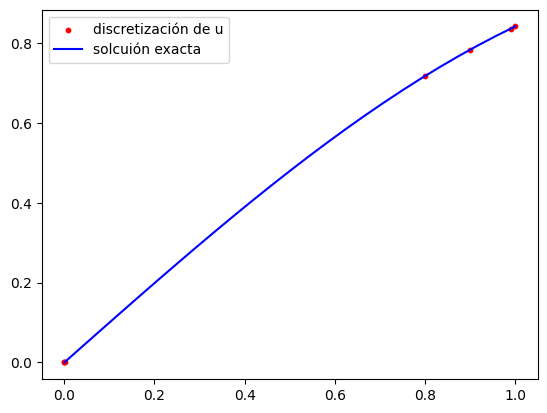

In [2]:
import numpy as np
from scipy.special import roots_legendre
from functools import partial
import matplotlib.pyplot as plt

def gauss1d(fun, x0, x1):
    n = 5
    xi, wi = roots_legendre(n)
    inte = 0
    h = 0.5 * (x1 - x0)
    xm = 0.5 * (x0 + x1)
    for cont in range(n):
        inte += h * fun(h * xi[cont] + xm) * wi[cont]
    return inte


f = lambda x: np.sin(x)
A = 0
B = np.sin(1)
n = 5
# pp = np.array([i/n for i in range(n+1)])
pp = np.array([0,0.001,0.8,0.9,0.99,1])
h = np.diff(pp)

Amatrix = np.zeros((n+1,n+1),float)
for i in range(n):
  Amatrix[i][i] += 1/h[i]
  Amatrix[i+1][i] = -1/h[i]
  Amatrix[i][i+1] = -1/h[i]
  Amatrix[i+1][i+1] = 1/h[i]

phi0_e = lambda x,i: 1-x/h[i]
phi1_e = lambda x,i: x/h[i]
ftimesphi0_e = lambda x,i: f(x+pp[i])*phi0_e(x,i)
ftimesphi1_e = lambda x,i: f(x+pp[i])*phi1_e(x,i)


b = np.zeros(n+1,float)
for i in range(n):
  aux0 = partial(ftimesphi0_e, i = i)
  aux1 = partial(ftimesphi1_e, i = i)
  b[i]+= gauss1d(aux0, 0, h[i])
  b[i+1]=gauss1d(aux1, 0, h[i])

'''
    Imponiendo condiciones iniciales:
'''

b[0] = A
b[n] = B
b[1] += A/h[0]
b[n-1] += B/h[n-1]
Amatrix[0][0] = 1
Amatrix[n][n] = 1
Amatrix[1][0] = 0
Amatrix[0][1] = 0
Amatrix[n-1][n] = 0
Amatrix[n][n-1] = 0

alfa = np.linalg.solve(Amatrix,b)

'''
    Definiendo los phi para retornar la combincación lineal de alfa_i phi_i(x)
'''

pseudophi1 = lambda x,i: (x-pp[i-1])/(pp[i]-pp[i-1])
pseudophi2 = lambda x,i: (x-pp[i+1])/(pp[i]-pp[i+1])

def phi0(x):
  if x <= pp[1]:
    return pseudophi2(x,0)
  else:
    return 0

def phin(x):
  if x >= pp[n-1]:
    return pseudophi1(x,n)
  else:
    return 0


#definiendo los phi_i(x):
def phi(x,i):
  if np.logical_and( x >= pp[i-1], x < pp[i]):
    return pseudophi1(x,i)
  if np.logical_and(x >= pp[i] , x < pp[i+1]):
    return pseudophi2(x,i)
  else:
    return 0

def uh(x):
  z = alfa[0]*phi0(x) + alfa[n]*phin(x)
  for i in range(1,n):
    z += alfa[i]*phi(x,i)
  return z

xx = np.linspace(0,1,25)
plt.scatter(0,uh(0),c = 'red',s = 10,label='discretización de u')
for x in pp:
  plt.scatter(x,uh(x),c = 'red',s = 10)
plt.plot(xx, np.sin(xx),label='solcuión exacta', c= 'blue')
plt.legend()